# TP: Introduction to Pytorch

## Auto-differential and optimization in Pytorch

### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Forward/Backward propagation and SGD

Assume $x_t \in \mathbb{R}$ and $\theta \in \mathbb{R}$. We want to optimize $\theta$ so that $x_t$ is close to a target value under the following linear dynamics:
$$
x_{t+1} = x_t + \theta
$$

Assume that $x_0$ is random, our goal is to minimize the following objective function:
$$
L_t = \mathbb{E}_{x_0 \sim p}[(x_t - 1)^2]
$$

1. Assume that $p \sim \mathcal{N}(1, 1)$. Use $m_b = 2024$ samples to estimate the expetation $L_t$.

In [3]:
# Define the dynamics function
def f(x, theta):
    return x + theta

# Define the loss function
def loss(x_t, target=1):
    return (x_t - target)**2

# Parameters
theta = torch.tensor(1.0, requires_grad=True)  # Initial value for theta
T = 20  # Number of time steps
m_b = 2024  # Number of samples

In [4]:
# Draw samples from the distribution p ~ N(1, 1)
x0_samples = torch.normal(1, 1, size=(m_b,))

# Loop over the samples
losses = []
for x0 in x0_samples:
    x = x0
    for _ in range(T):
        x = f(x, theta)
    losses.append(loss(x))
    
# Compute the mean loss
Lt = torch.mean(torch.stack(losses))
print("Estimated L_t:", Lt.item())

Estimated L_t: 400.7417297363281


2. Compute automatically the derivative of $L_t$ with respect to $\theta$.

In [5]:
# Compute the gradient
Lt.backward()
print("Gradient:", theta.grad.item())

Gradient: 799.7713623046875


3. Assume $T = 20$ and $\theta = 1$, what is the loss $L_T$ and its gradient? Implement a gradient descent algorithm with constant step-size to minimize $L_T$ with respect to $\theta$, starting from $\theta = 1$.

In [6]:
def gradient_descent(theta, x0_samples, learning_rate, num_iterations, T, m_b):
    loss_over_iterations = []

    # Gradient descent loop
    for iteration in range(num_iterations):
        # Initialize the loss for this iteration
        losses = []

        # Loop over the samples
        for x0 in x0_samples:
            x = x0
            for _ in range(T):
                x = f(x, theta)
            losses.append(loss(x))

        # Compute the mean loss
        Lt = torch.mean(torch.stack(losses))

        # Compute the gradient of the loss with respect to theta
        Lt.backward()

        # Update theta using gradient descent
        with torch.no_grad():
            theta -= learning_rate * theta.grad

        # Zero the gradients for the next iteration
        theta.grad.zero_()

        # Store the loss for this iteration
        loss_over_iterations.append(Lt.item())

        # Print the loss and theta for monitoring
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Loss = {Lt.item()}, Theta = {theta.item()}")

    return loss_over_iterations

Iteration 10: Loss = 89.9639892578125, Theta = 0.4348873198032379
Iteration 20: Loss = 17.74458122253418, Theta = 0.18941080570220947
Iteration 30: Loss = 4.117246150970459, Theta = 0.08277840912342072
Iteration 40: Loss = 1.5458316802978516, Theta = 0.03645840659737587
Iteration 50: Loss = 1.0606269836425781, Theta = 0.016337549313902855
Iteration 60: Loss = 0.9690689444541931, Theta = 0.007597242947667837
Iteration 70: Loss = 0.9517931342124939, Theta = 0.0038005325477570295
Iteration 80: Loss = 0.9485328197479248, Theta = 0.0021512943785637617
Iteration 90: Loss = 0.9479182958602905, Theta = 0.0014348850818350911
Iteration 100: Loss = 0.9478013515472412, Theta = 0.0011236827122047544


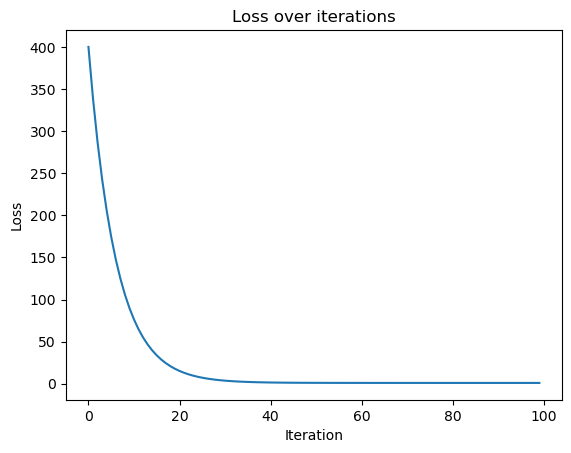

In [7]:
# Parameters
theta = torch.tensor(1.0, requires_grad=True)  # Initial value for theta
T = 20  # Number of time steps
m_b = 2024  # Number of samples
learning_rate = 1e-4  # Step size for gradient descent
num_iterations = 100  # Number of iterations for gradient descent

# Draw samples from the distribution p ~ N(1, 1)
x0_samples = torch.normal(1, 1, size=(m_b,))

# Call the function
loss_over_iterations = gradient_descent(theta, x0_samples, learning_rate, num_iterations, T, m_b)

# Display the loss over iterations
plt.plot(loss_over_iterations)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()

4. Use $\texttt{torch.optim.SGD}$ to minimize $L_T$. What is the optimal solution that you have found?

In [8]:
import torch.optim as optim

In [9]:
def gradient_descent_optim(theta, x0_samples, learning_rate, num_iterations, T, m_b):
    loss_over_iterations = []

    # Define the optimizer
    optimizer = optim.SGD([theta], lr=learning_rate)

    # Gradient descent loop
    for iteration in range(num_iterations):
        # Initialize the loss for this iteration
        losses = []

        # Loop over the samples
        for x0 in x0_samples:
            x = x0
            for _ in range(T):
                x = f(x, theta)
            losses.append(loss(x))

        # Compute the mean loss
        Lt = torch.mean(torch.stack(losses))

        # Zero the gradients from the previous iteration
        optimizer.zero_grad()

        # Compute the gradient of the loss with respect to theta
        Lt.backward()

        # Update theta using gradient descent
        optimizer.step()

        # Store the loss for this iteration
        loss_over_iterations.append(Lt.item())

        # Print the loss and theta for monitoring
        if (iteration + 1) % 10 == 0:
            print(f"Iteration {iteration + 1}: Loss = {Lt.item()}, Theta = {theta.item()}")

    return loss_over_iterations

Iteration 10: Loss = 89.86368560791016, Theta = 0.4352448880672455
Iteration 20: Loss = 17.733922958374023, Theta = 0.18992064893245697
Iteration 30: Loss = 4.123459815979004, Theta = 0.08335395902395248
Iteration 40: Loss = 1.5552617311477661, Theta = 0.03706290200352669
Iteration 50: Loss = 1.0706613063812256, Theta = 0.016954559832811356
Iteration 60: Loss = 0.979220986366272, Theta = 0.008219697512686253
Iteration 70: Loss = 0.9619648456573486, Theta = 0.004425389692187309
Iteration 80: Loss = 0.9587098956108093, Theta = 0.0027771887835115194
Iteration 90: Loss = 0.9580956697463989, Theta = 0.0020612350199371576
Iteration 100: Loss = 0.9579794406890869, Theta = 0.0017502347473055124


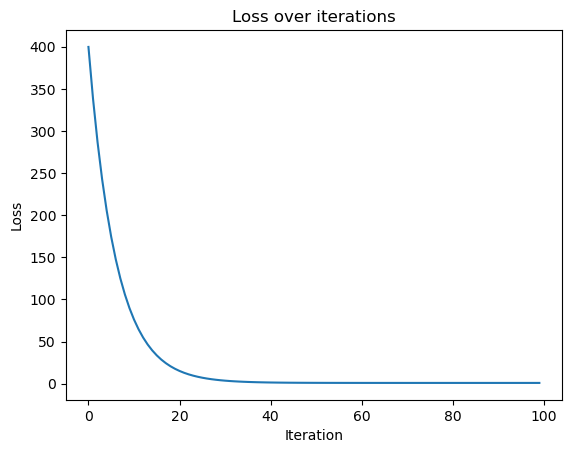

In [10]:
# Parameters
theta = torch.tensor(1.0, requires_grad=True)  # Initial value for theta
T = 20  # Number of time steps
m_b = 2024  # Number of samples
learning_rate = 1e-4  # Step size for gradient descent
num_iterations = 100  # Number of iterations for gradient descent

# Draw samples from the distribution p ~ N(1, 1)
x0_samples = torch.normal(1, 1, size=(m_b,))

# Call the function
loss_over_iterations = gradient_descent_optim(theta, x0_samples, learning_rate, num_iterations, T, m_b)

# Display the loss over iterations
plt.plot(loss_over_iterations)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()

### Visualize the computational graph

In [11]:
import torchviz

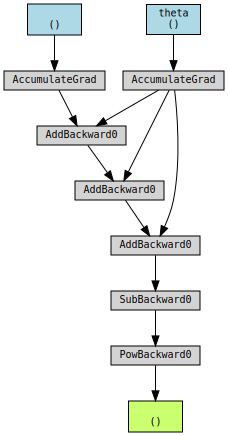

In [12]:
# Draw the computational graph
T = 3
x0 = torch.tensor(1.0, requires_grad=True)
x = x0
for _ in range(T):
    x = f(x, theta)
Lt = loss(x)
Lt.backward()
torchviz.make_dot(Lt, params={"theta": theta})